In [1]:
import sys
sys.path.append('../')
import logging

import pandas as pd
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

from lstm_mobility_model.two_layer_categorical_location import TwoLayerLstmCategoricalLocationModelBuilder
from lstm_mobility_model.load import DataPreprocessor

logger = logging.getLogger()
logger.setLevel(logging.INFO)

%matplotlib inline

### Data Preprocessing
Preprocess the data to get location ID from latitude and longitude using DBScan.
Produce a map from location ID to latitude and longitude.

In [2]:
def preprocess_data(dataframe):
    processor = DataPreprocessor()
    return processor.preprocess_traces_to_dict(dataframe)

def get_location_id(traces, eps=0.003):
    points = traces[['lat', 'lon']].values
    labels = DBSCAN(eps=eps, min_samples=1).fit_predict(points)
    traces['location_category'] = labels

def get_location_id_latlng_map(traces):
    labels = traces['location_category']
    location_lat_lng_map = {}
    for i in range(max(labels) + 1):
        traces_ = traces[labels == i]
        location_lat_lng_map[i] = (np.mean(traces_['lat'].values),
                                   np.mean(traces_['lon'].values))
    return location_lat_lng_map

In [3]:
dataframe = pd.read_csv('../sample_data/sample_data_0.csv')
get_location_id(dataframe)
preprocessed_data = preprocess_data(dataframe)
location_lat_lng_map = get_location_id_latlng_map(dataframe)

### LSTM mobility model

In [4]:
lstm_model = \
    TwoLayerLstmCategoricalLocationModelBuilder(
        model_path='lstm_model_weights/',
        model_name='two_layer_categorical_location',
        learning_rate=0.01,
        training_epochs=5000,
        lstm_dropout=0.0,
        lstm_units=16,
        number_of_mixtures=10,
        sampling_bias=0.0,
        location_lat_lng_map=location_lat_lng_map)

In [5]:
lstm_model.train(preprocessed_data,
                 batch_size=100)

INFO:root:Epoch: 500 Loss: [  2.4123387 -14.282864 ]
INFO:root:Epoch: 1000 Loss: [  1.1682156 -26.49015  ]
INFO:root:Epoch: 1500 Loss: [  0.995168 -29.415257]
INFO:root:Epoch: 2000 Loss: [  0.93656135 -30.92907   ]
INFO:root:Epoch: 2500 Loss: [  0.90036666 -32.77971   ]
INFO:root:Epoch: 3000 Loss: [  0.86448985 -33.60339   ]
INFO:root:Epoch: 3500 Loss: [  0.84408116 -34.654694  ]
INFO:root:Epoch: 4000 Loss: [  0.818288 -35.418045]
INFO:root:Epoch: 4500 Loss: [  0.79873425 -35.914944  ]
INFO:root:Epoch: 5000 Loss: [  0.7742708 -36.557796 ]
INFO:root:Saved model to lstm_model_weights/two_layer_categorical_location


In [6]:
generated_traces = lstm_model.generate(
    preprocessed_data,
    method='complete')
generated_traces_df = pd.concat(list(generated_traces.values()))

### Compare observed sequence to generated sequence

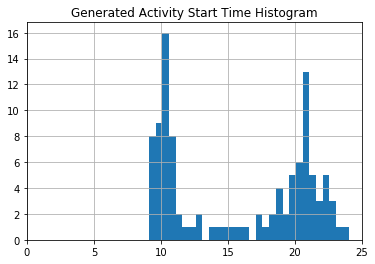

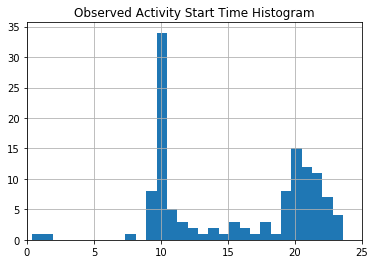

In [7]:
_ = plt.figure()
_ = generated_traces_df[generated_traces_df['start_hour_since_day'] != 0][
    'start_hour_since_day'].hist(bins=30)
_ = plt.title('Generated Activity Start Time Histogram')
_ = plt.xlim(0, 25)

_ = plt.figure()
_ = dataframe[dataframe['start_hour_since_day'] != 0][
    'start_hour_since_day'].hist(bins=30)
_ = plt.title('Observed Activity Start Time Histogram')
_ = plt.xlim(0, 25)

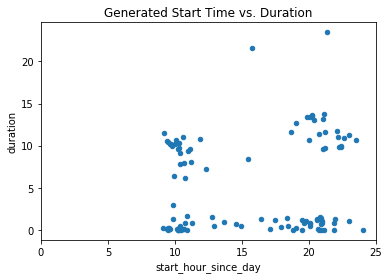

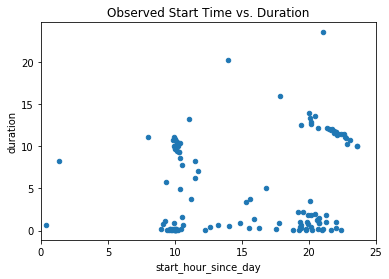

In [8]:
_ = generated_traces_df[generated_traces_df['start_hour_since_day'] != 0].plot.scatter(
    x='start_hour_since_day',
    y='duration')
_ = plt.title('Generated Start Time vs. Duration')
_ =plt.xlim(0, 25)

_ = dataframe[dataframe['start_hour_since_day'] != 0].plot.scatter(
    x='start_hour_since_day',
    y='duration')
_ = plt.title('Observed Start Time vs. Duration')
_ = plt.xlim(0, 25)

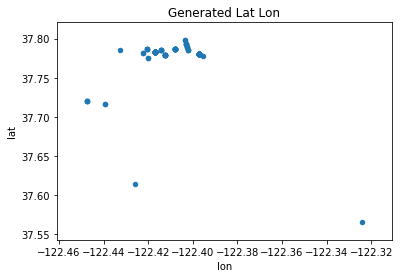

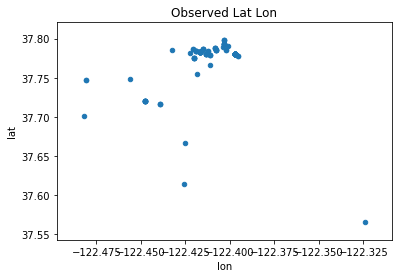

In [9]:
_ = generated_traces_df[generated_traces_df['start_hour_since_day'] != 0].plot.scatter(
    x='lon',
    y='lat')
_ = plt.title('Generated Lat Lon')

_ = dataframe[dataframe['start_hour_since_day'] != 0].plot.scatter(
    x='lon',
    y='lat')
_ = plt.title('Observed Lat Lon')